<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


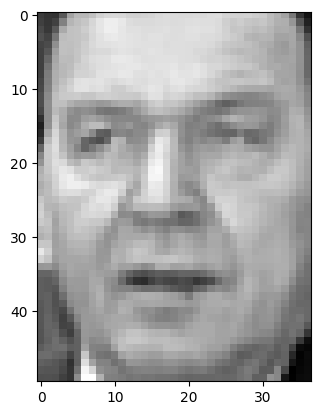

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]

0.43286065070595453

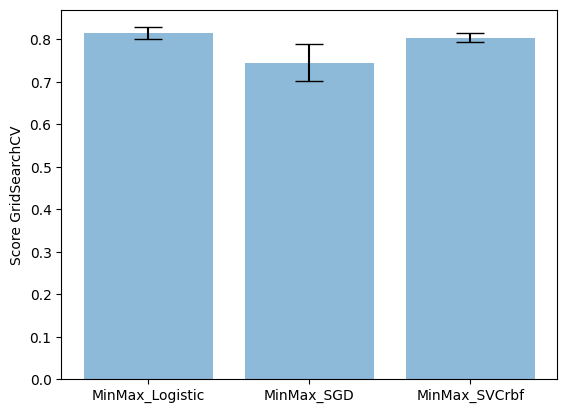

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.745 0.804]
 [0.014 0.043 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/).

Evaluando modelo MinMax_Logistic (1/3)


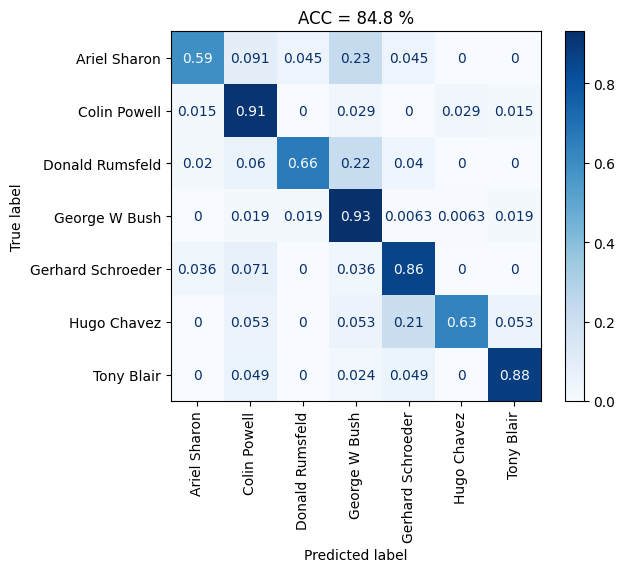

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


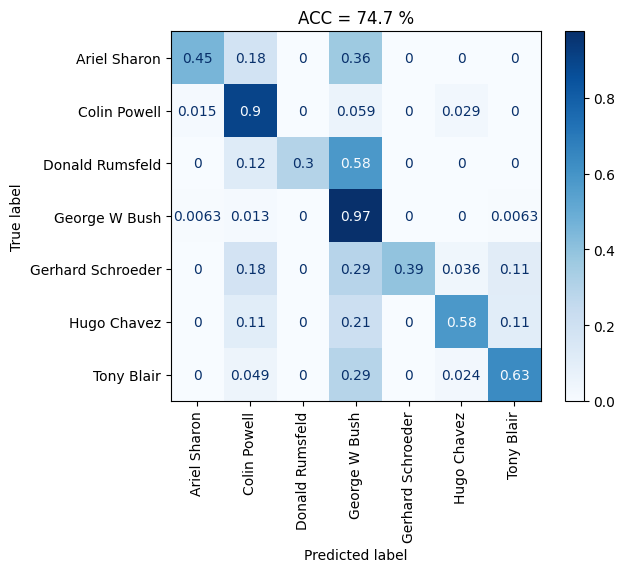

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.45      0.59        22
     Colin Powell       0.74      0.90      0.81        68
  Donald Rumsfeld       1.00      0.30      0.46        50
    George W Bush       0.70      0.97      0.82       159
Gerhard Schroeder       1.00      0.39      0.56        28
      Hugo Chavez       0.73      0.58      0.65        19
       Tony Blair       0.81      0.63      0.71        41

         accuracy                           0.75       387
        macro avg       0.83      0.60      0.66       387
     weighted avg       0.79      0.75      0.72       387

Evaluando modelo MinMax_SVCrbf (3/3)


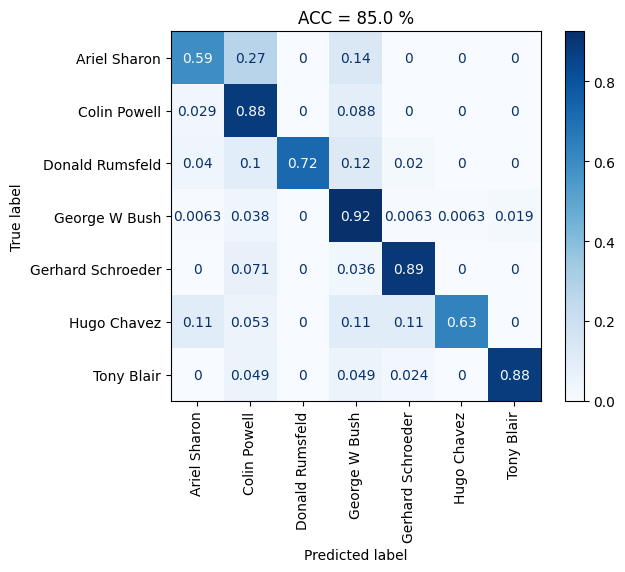

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest, ytest_e)

    disp = ConfusionMatrixDisplay.from_estimator(
                          my_model_loaded[i].best_estimator_, Xtest, ytest,
                          display_labels=lfw_people.target_names,
                          normalize='true',  # Si deseas normalizar la matriz
                          cmap=plt.cm.Blues
                          )
    disp.ax_.set_title('ACC = %.1f %%' % (100*acc))
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje x a 90 grados
    plt.autoscale()
    # save_fig(path_img, label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


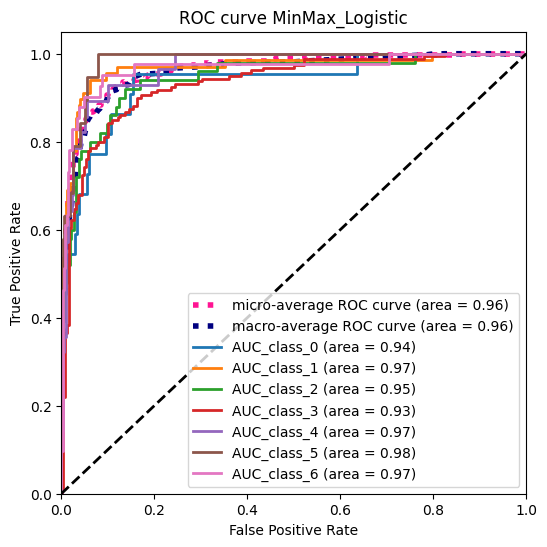

Evaluando modelo MinMax_SGD (2/3)


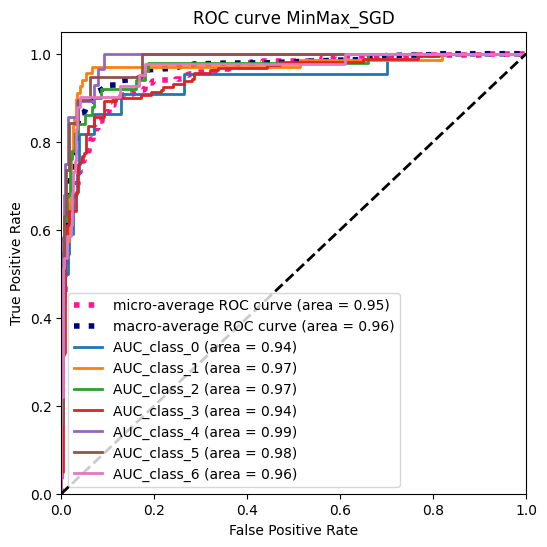

Evaluando modelo MinMax_SVCrbf (3/3)


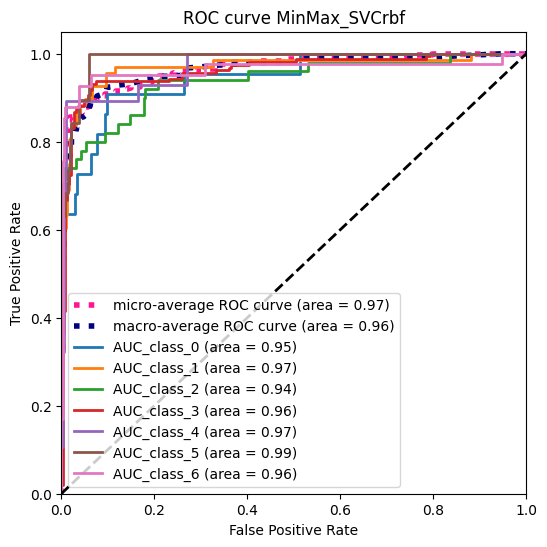

In [10]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.


**Naive Bayes Gaussian**

Es un modelo de probabilidad condicional donde se asignan probabilidades $p(C_k | x_1, \cdots , x_n)$ para cada uno de los posibles $K$ posibles resultados o clases $C_k$ dada una instancia que se va a clasificar representada por $\textbf{x}=(x_1 , \cdots , x_n)$ codificando algunas $n$ características.
\
Si se toma que todas las características $\textbf{x}$ son mutuamente independientes condicionadas a la categoría $C_k$, se puede expresar el modelo conjunto como:
$p(C_k | x_1 , \cdots , x_n) = p(C_k) \prod_{i=1}^{n}{p(x_i|C_k)}$
\
Por lo que entonces el clasificador de Bayes ingenuo gaussiano queda expresado como: $\hat{y}= \arg \max_{k \in 1, \cdots , K} p(C_k)\prod_{i=1}^{n}{(x_i|C_k)}$, si se toma $p(x_i|C_k)=\mathcal{N}(x_i|\mu_{i,k},\sigma_{i,k}^{2})$

**Clasificador SGD**

Es un algoritmo de optimización que se utiliza para entrenar modelos de clasificación, el cuál es necesario combinarlo con un clasificador lineal, esto para conseguir predecir una etiqueta $y$ a partir de un vector de características $x$.
\
Por lo que la tarea es encontrar un $f(x)=w^{T}x+b$ que consiga esto (siendo $w$ el vector de pesos y $b$ el sesgo), lo cual se consigue si se minimiza la función de pérdida, es decir, $\arg \min L(y,\hat{y})$ reducir la diferencia entre la etiqueta $y$ verdadera y la estimada por el modelo $\hat{y}$.
\
Para esto el algotrimo SGD ajusta $w$ y $b$ en cada iteración en la dirección del gradiente negativo, hasta que la función de pérdida converge o alcanza un valor aceptable, todo esto aplicando la regla: $w \leftarrow w - \alpha \nabla_{w}L$ y $b \leftarrow b - \alpha \nabla_{b}L$, donde $\alpha$ es la tasa de aprendizaje.

**Regresión Logística:**

Es un modelo de clasificación que se utiliza para predecir la probabilidad de que una muestra $n$ pertenezca a una clase $k$.
\
Si tomamos un conjunto $N$ de muestras tal que $\{(x_1,y_1),\cdots , (x_N,y_N)\}$ donde $x_i$ es el vector de características y $y_i$ es la etiqueta asociado que puedo tomar $K$ valores diferentes, siendo $K$ el número de clases.
\
La estimación de que $x$ pertenezca a una clase $k$ está dada por: $\hat{y}=P(y=k|x)=\frac{e^{w^T}k^{x+b_k}}{\sum_{K}^{j=1}{e^{(w_{j}^{T}x+b_j)}}}$, en donde $w$ es el vector de pesos y $b$ el sesgo.
\
Lo cual se consigue si se minimiza la función de pérdida, es decir, $\arg \min L(y,\hat{y})$ reducir la diferencia entre la etiqueta $y$ verdadera y la estimada por el modelo $\hat{y}$. Siendo el algoritmo SGD un método para lograrlo.

**Análisis Discriminante Lineal:**

Es un método de clasificación en el que dos o más grupos son conocidos a priori y nuevas observaciones se clasifican en uno de ellos en función de sus características.
\
Si tomamos un conjunto $N$ de muestras con distribución gaussiana multivariada tal que $\{(x_1,y_1),\cdots , (x_N,y_N)\}$ donde $x_i$ es el vector de características y $y_i$ es la etiqueta asociado que puedo tomar $K$ valores diferentes, siendo $K$ el número de clases.
\
Si e asume que la matrices de covarianza son iguales $\Sigma_{\textbf{A}}=\Sigma_{\textbf{B}}=\Sigma$, además de que las clases tienen la misma probabilidad a priori $\pi_1 = \pi_2 = \cdots = \pi_K$, la estimación de que $x$ pertenezca a una clase $k$ está dada por: $\hat{y}=P(y=k|x)=\frac{(\mu_k -\textbf{x})^T \textbf{x}}{\sum_{l=1}^{K}{(\mu_l)^T \textbf{x}}}$, donde $\mu_k$ es el vector de las medias de las característica de la clase $k$ el cual se calcula como $\mu_{k,i}=\frac{\sum_{j=1}^{n_k}{x_{j,i}}}{n_k}$

**Clasificador K-Neighbors:**

Es un algoritmo de clasificación que se basa en la cercanía de los puntos en el espacio de características.
\
Si tomamos un conjunto $N$ de muestras con distribución gaussiana multivariada tal que $\{(x_1,y_1),\cdots , (x_N,y_N)\}$ donde $x_i$ es el vector de características y $y_i$ es la etiqueta asociado que puedo tomar $K$ valores diferentes, siendo $K$ el número de clases.
\
La estimación de que dado una muestra $n$ con características $x$ que corresponda a una clase $k$ se determina mediante la moda de las etiquetas de los $K$ vecinos más cercanos a $x$, esto dado que se calcula la distancia entre $x$ y el resto de puntos, es decir, $d(x_i,x_j)=\sqrt{\sum_{p=1}^{P}{(x_i^p-x_j^p)^2}}$, donde $P$ es la cantidad de dimensiones.

La estimación de que dado una muestra $n$ con características $x$ pertenezca a una clase está dado por  donde $SV$ son los vectores de soporte.


**SVC:**

Es un algoritmo de para problemas de clasificación cuyo objetivo es encontrar un hiperplano en un espacio de características que separe de manera óptima las diferentes clases de datos.
\
Dado un conjunto de entrenamiento de la forma $((x_1, y_1), (x_2, y_2), ..., (x_n, y_n))$, donde $(x_i)$ es un vector de características y $(y_i)$ es la etiqueta de clase correspondiente que puede ser -1 o 1, para casos biclase.
\
La estimación de que dado una muestra $n$ con características $x$ pertezneca a una clase está dado por $\hat{y} = \operatorname{sign}\left(\sum_{i \in SV} y_i \alpha_i K(x_i , x) + b\right)$, donde $SV$ son los vectores de soporte.
\
Esto se logra si minimiza la función objetivo $\min_{w,b,\zeta} \frac{1}{2}w^T w + C \sum_{i=1}^{n}{\zeta_i}$, donde $w$ es el vector de pesos, $b$ el sesgo, $\zeta_i$ son las variables de holgura que permiten que algunas muestras estén dentro del margen o mal clasificadas y $C$ que es un hiperparámetro que controla la importancia relativa de la maximización del margen y la minimización de errores de clasificación.
\
Esto sujeto a las restricciones que $y_i(w^T\phi(x_i)+b)\geq 1- \zeta_i , \zeta_i \geq 0, i=1, \cdots , n$

**Random Forest:**

Es un algoritmo cuyo objetivo es la construcción de múltiples árboles de decisión para llevar a cabo una clasificación.
\
Dado un conjunto de entrenamiento de la forma $((x_1, y_1), (x_2, y_2), ..., (x_n, y_n))$, donde $(x_i)$ es un vector de características y $(y_i)$ es la etiqueta de clase correspondiente cuyo asignación es $K$, siendo $K$ el número de clases.
\
La estimación de que una muestra $n$ con caracterísiticas $x$ pertenezca a una clase $K$ se obtiene tomando la moda de las etiquetas de las muestras en las hojas de los árboles que "votan" por la clase de $n$. Lo cual se logra minimizando la impureza Gini, es decir, $\arg\min\text{Gini}(N)=1-\sum_{k=1}^{K}{(p_k)^2})$ que construye cada árbol del bosque y esta impureza se disminuye aplicando el algoritmo CART que divide el conjunto $N$ en dos subconjuntos $N_{izq}$ y $N_{der}$ mediante una regla de la forma $(x_j \leq t)$ o $(x_j > t)$ para alguna característica $(j)$ y umbral $(t)$, de manera que se minimiza la impureza ponderada de los dos subconjuntos resultantes.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Crear listas de pipelines sin GaussianProcessClassifier
steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],
    [('nor', MinMaxScaler()), ('cla', SVC())],
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],
    [('nor', MinMaxScaler()), ('cla', LinearSVC())],
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())]
]

# Definir los hiperparámetros para GridSearchCV
parameters = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},
    {'cla__C': [1, 10, 1e2, 1e3, 1e4], 'cla__gamma': [1e-3, 1e-2, 1e-1, 1, 10]},
    {'cla__var_smoothing': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    {'cla__solver': ['svd'], 'cla__tol': [1e-4, 1e-3]},
    {'cla__n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
    {'cla__C': [1, 10, 1e2, 1e3, 1e4]},
    {'cla__n_estimators': [150], 'cla__max_features': [5, 7, 9], 'cla__max_depth': [None, 3, 10, 20]}
]

label_models = [
    'MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMaxGaussianNB',
    'MinMaxL_D_Analysis', 'MinMaxKNeighbors', 'MinMaxLinearSVC', 
    'MinMaxRandomForest'
]

# Definir la ubicación del archivo para guardar los modelos
filename = 'results/lfw_models'

models = []
for i in range(len(steps)):  # Recorrer modelos según la lista pipeline
    print('Modelo %d/%d' % (i+1, len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1, cv=5,
                               scoring='accuracy', refit=True, verbose=10)
    grid_search.fit(Xtrain, ytrain)  # Entrenar el modelo
    models.append(grid_search)  # Guardar modelo entrenado

# Guardar todos los modelos en un archivo
joblib.dump(models, filename+".pkl")


Modelo 1/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Modelo 2/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Modelo 3/8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Modelo 4/8
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 3/5; 1/7] START cla__C=0.001................................................
[CV 3/5; 1/7] END .................cla__C=0.001;, score=0.444 total time=   1.9s
[CV 5/5; 1/7] START cla__C=0.001................................................
[CV 5/5; 1/7] END .................cla__C=0.001;, score=0.439 total time=   1.8s
[CV 4/5; 2/7] START cla__C=0.01.................................................
[CV 4/5; 2/7] END ..................cla__C=0.01;, score=0.622 total time=   1.8s
[CV 3/5; 3/7] START cla__C=0.1..................................................
[CV 3/5; 3/7] END ...................cla__C=0.1;, score=0.756 total time=   1.8s
[CV 3/5; 4/7] START cla__C=1....................................................
[CV 3/5; 4/7] END .....................cla__C=1;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Modelo 8/8
Fitting 5 folds for each of 12 candidates, totalling 60 fits


['results/lfw_models.pkl']

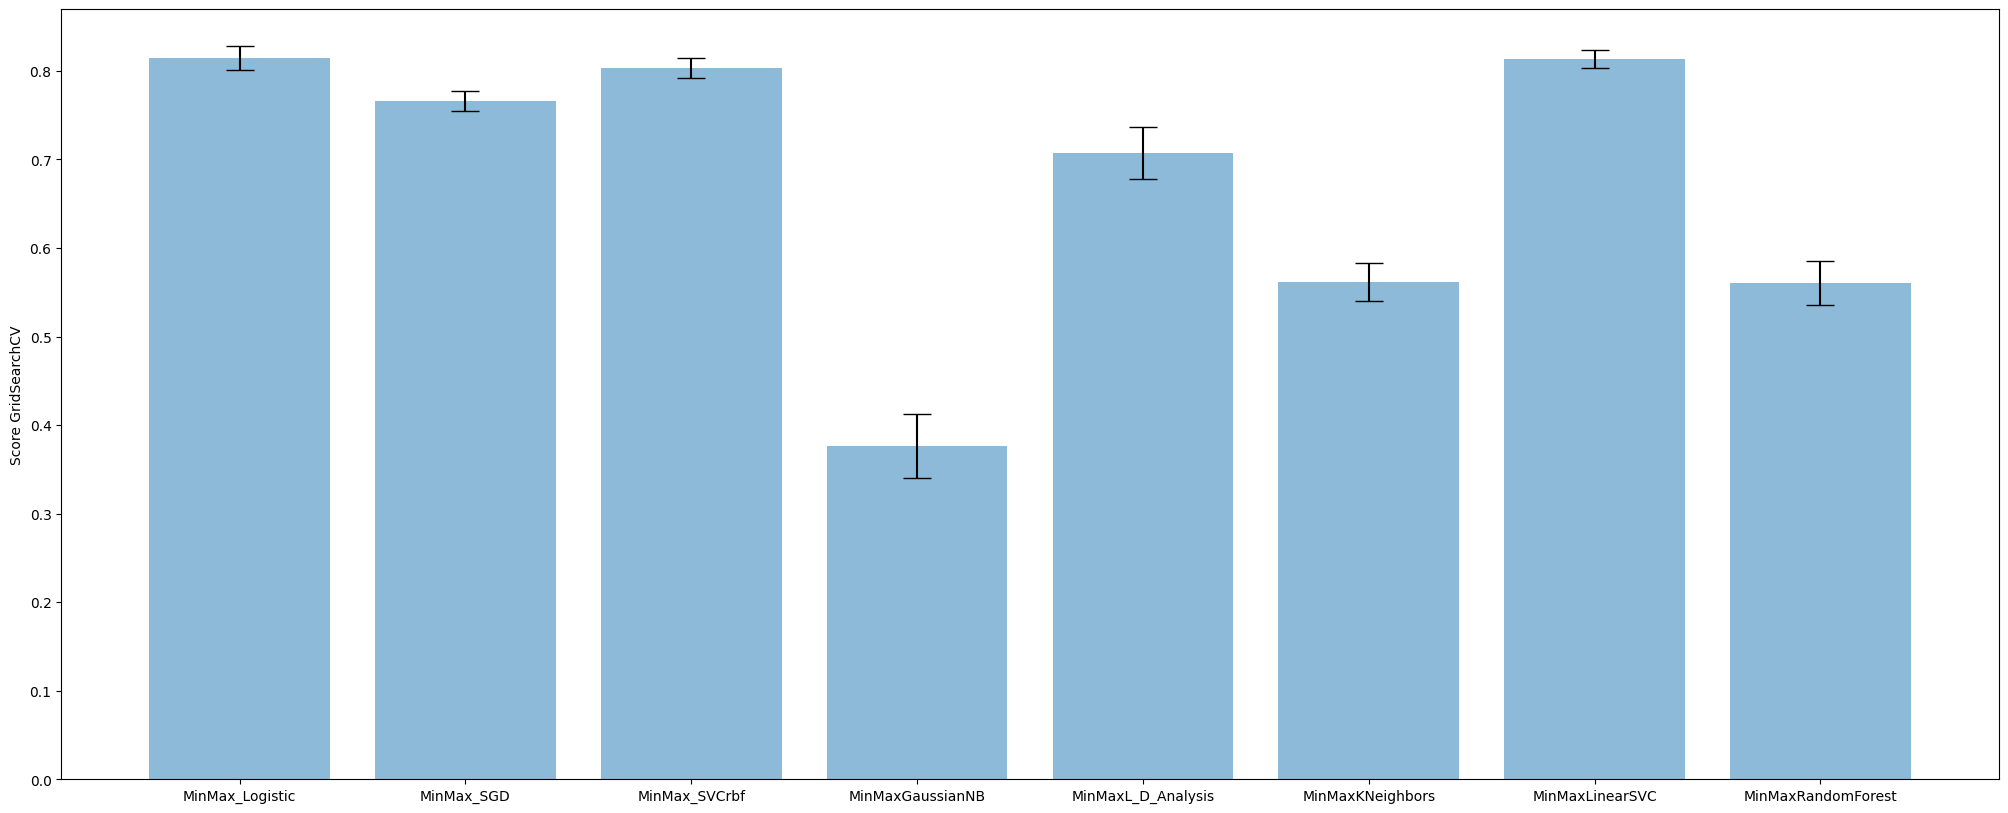

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMaxGaussianNB', 'MinMaxL_D_Analysis', 'MinMaxKNeighbors', 'MinMaxLinearSVC', 'MinMaxRandomForest']
[[0.815 0.766 0.804 0.376 0.707 0.562 0.814 0.56 ]
 [0.014 0.011 0.011 0.036 0.029 0.021 0.01  0.025]]


In [25]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.figure(figsize=(25,10))
plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

Evaluando modelo MinMax_Logistic (1/8)


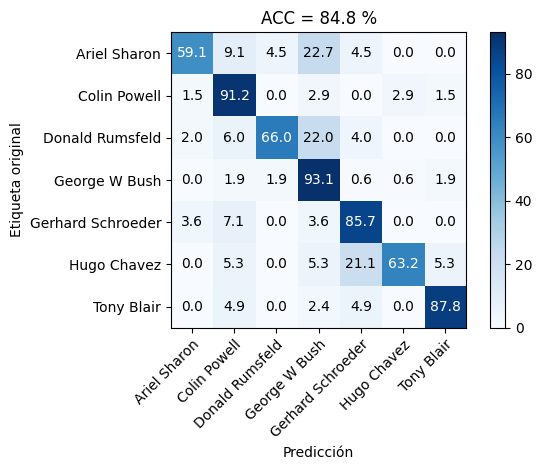

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/8)


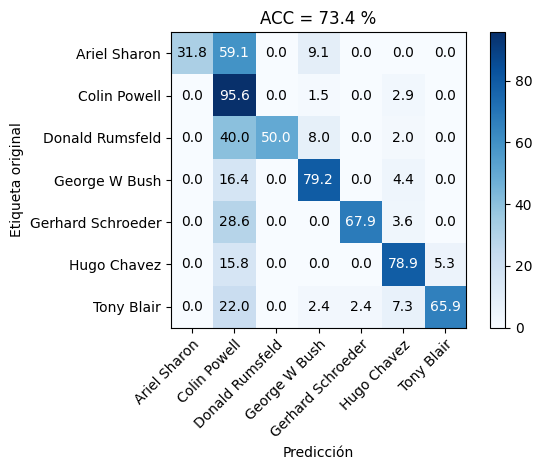

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.32      0.48        22
     Colin Powell       0.45      0.96      0.61        68
  Donald Rumsfeld       1.00      0.50      0.67        50
    George W Bush       0.94      0.79      0.86       159
Gerhard Schroeder       0.95      0.68      0.79        28
      Hugo Chavez       0.52      0.79      0.62        19
       Tony Blair       0.96      0.66      0.78        41

         accuracy                           0.73       387
        macro avg       0.83      0.67      0.69       387
     weighted avg       0.85      0.73      0.75       387

Evaluando modelo MinMax_SVCrbf (3/8)


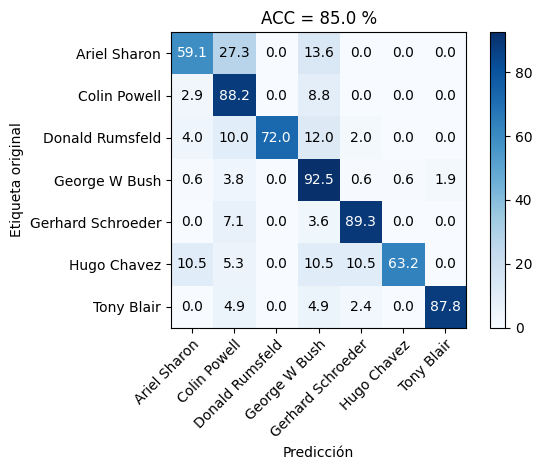

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo MinMaxGaussianNB (4/8)


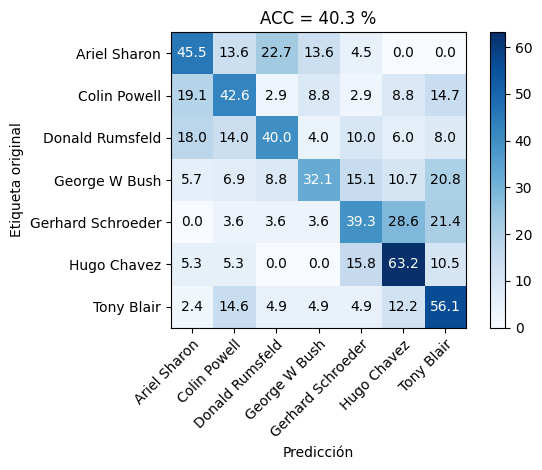

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMaxL_D_Analysis (5/8)


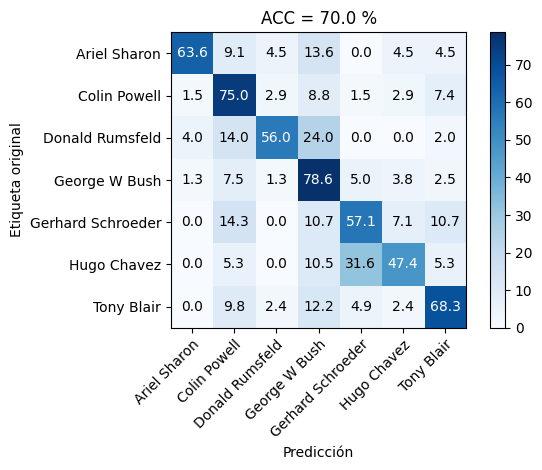

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo MinMaxKNeighbors (6/8)


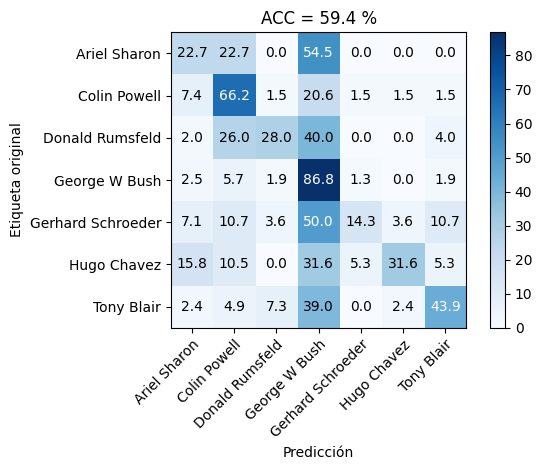

                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.23      0.23        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       0.64      0.28      0.39        50
    George W Bush       0.63      0.87      0.73       159
Gerhard Schroeder       0.50      0.14      0.22        28
      Hugo Chavez       0.67      0.32      0.43        19
       Tony Blair       0.64      0.44      0.52        41

         accuracy                           0.59       387
        macro avg       0.55      0.42      0.45       387
     weighted avg       0.59      0.59      0.56       387

Evaluando modelo MinMaxLinearSVC (7/8)


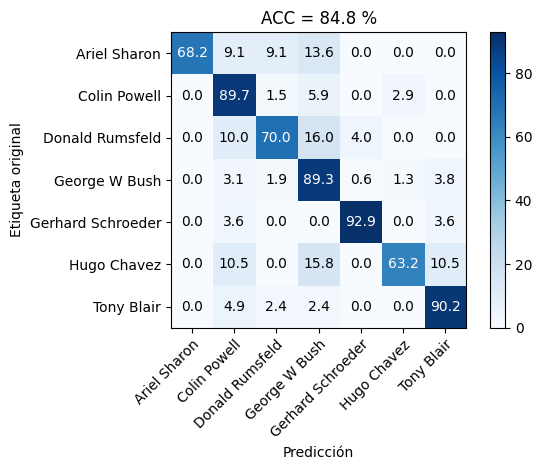

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.68      0.81        22
     Colin Powell       0.78      0.90      0.84        68
  Donald Rumsfeld       0.83      0.70      0.76        50
    George W Bush       0.88      0.89      0.89       159
Gerhard Schroeder       0.90      0.93      0.91        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.80      0.90      0.85        41

         accuracy                           0.85       387
        macro avg       0.85      0.80      0.82       387
     weighted avg       0.85      0.85      0.85       387

Evaluando modelo MinMaxRandomForest (8/8)


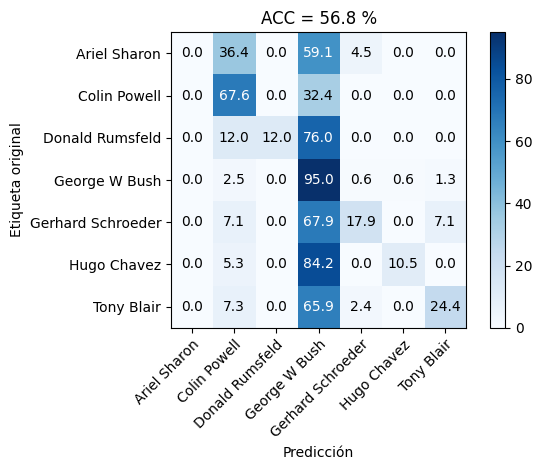

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.66      0.68      0.67        68
  Donald Rumsfeld       1.00      0.12      0.21        50
    George W Bush       0.53      0.95      0.68       159
Gerhard Schroeder       0.62      0.18      0.28        28
      Hugo Chavez       0.67      0.11      0.18        19
       Tony Blair       0.71      0.24      0.36        41

         accuracy                           0.57       387
        macro avg       0.60      0.32      0.34       387
     weighted avg       0.62      0.57      0.49       387



In [26]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

In [27]:
my_model_loaded

[GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('nor', MinMaxScaler()),
                                        ('cla', LogisticRegression())]),
              n_jobs=-1,
              param_grid={'cla__C': [0.001, 0.01, 0.1, 1, 10, 100.0, 1000.0]},
              scoring='accuracy', verbose=10),
 GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('nor', MinMaxScaler()),
                                        ('cla', SGDClassifier())]),
              n_jobs=-1,
              param_grid={'cla__alpha': [0.001, 0.01, 0.1, 1, 10, 100.0,
                                         1000.0]},
              scoring='accuracy', verbose=10),
 GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('nor', MinMaxScaler()),
                                        ('cla', SVC())]),
              n_jobs=-1,
              param_grid={'cla__C': [1, 10, 100.0, 1000.0, 10000.0],
                          'cla__gamma': [0.001, 0.01, 0.1, 1, 10]},
              scoring='accuracy', ver

Evaluando modelo MinMax_Logistic (1/8)


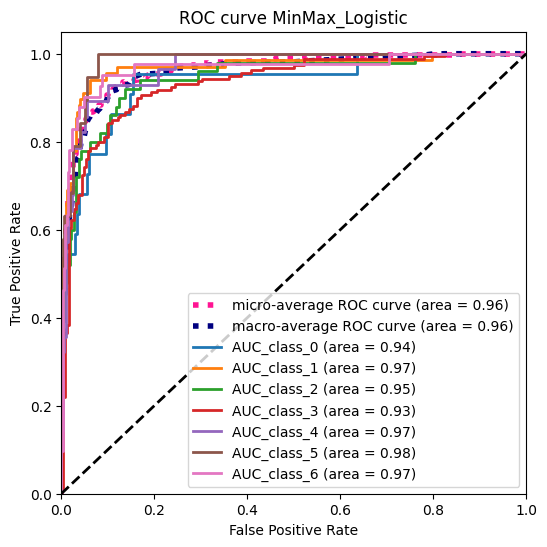

Evaluando modelo MinMax_SGD (2/8)


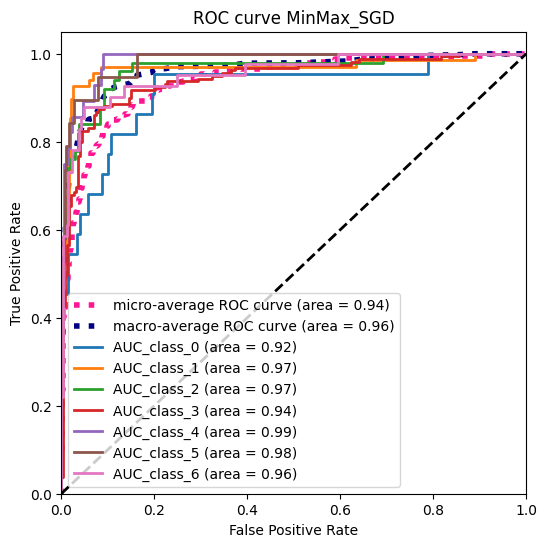

Evaluando modelo MinMax_SVCrbf (3/8)


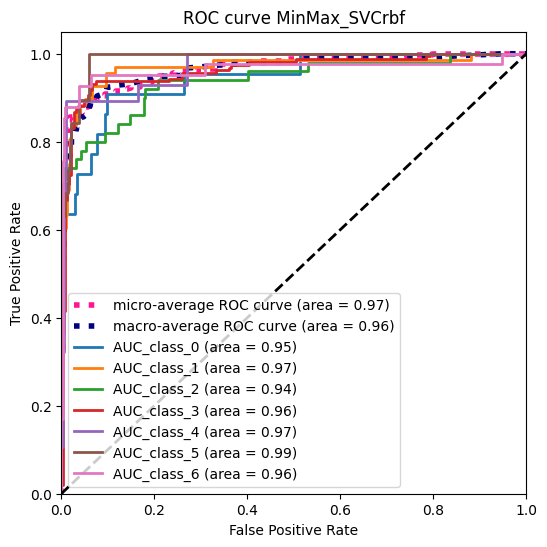

Evaluando modelo MinMaxL_D_Analysis (5/8)


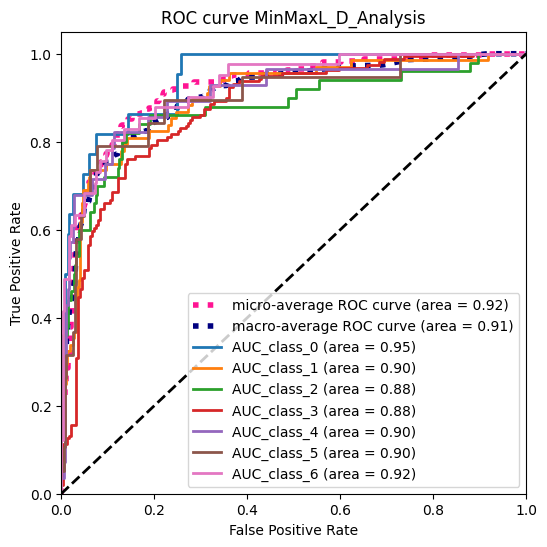

Evaluando modelo MinMaxLinearSVC (7/8)


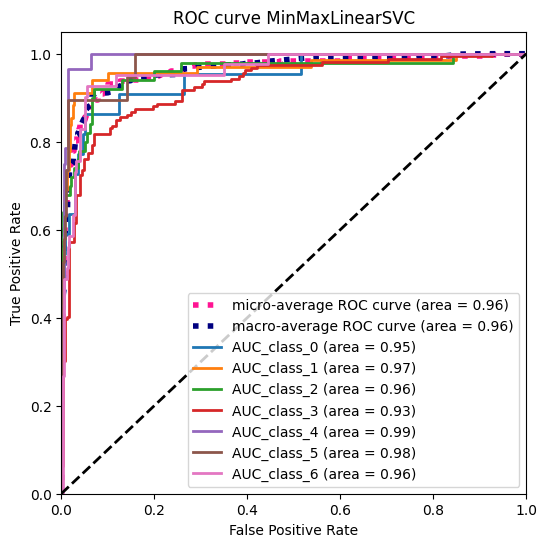

[CV 1/5; 1/5] START cla__var_smoothing=1e-05....................................
[CV 1/5; 1/5] END .....cla__var_smoothing=1e-05;, score=0.376 total time=   0.2s
[CV 1/5; 2/5] START cla__var_smoothing=0.0001...................................
[CV 1/5; 2/5] END ....cla__var_smoothing=0.0001;, score=0.376 total time=   0.2s
[CV 5/5; 2/5] START cla__var_smoothing=0.0001...................................
[CV 5/5; 2/5] END ....cla__var_smoothing=0.0001;, score=0.361 total time=   0.2s
[CV 3/5; 3/5] START cla__var_smoothing=0.001....................................
[CV 3/5; 3/5] END .....cla__var_smoothing=0.001;, score=0.339 total time=   0.2s
[CV 2/5; 4/5] START cla__var_smoothing=0.01.....................................
[CV 2/5; 4/5] END ......cla__var_smoothing=0.01;, score=0.450 total time=   0.2s
[CV 1/5; 5/5] START cla__var_smoothing=0.1......................................
[CV 1/5; 5/5] END .......cla__var_smoothing=0.1;, score=0.343 total time=   0.2s
[CV 5/5; 5/5] START cla__var

In [28]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    if i == 3:
      pass
    elif i==5:
      pass
    elif i==7:
      pass
    else:
      print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
      #debe calcularse la funcion de decision o el posterior de la probabilidad
      ytest_score = my_model_loaded[i].decision_function(Xtest)
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

*Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo*:

* **Logistic Regression (cla__C)**:

 El hiperparámetro C controla la regularización en la regresión logística. Valores pequeños de C aplican una mayor regularización, lo que puede prevenir el sobreajuste, mientras que valores más grandes permiten que el modelo se ajuste mejor a los datos de entrenamiento.
 
Rejilla: C ha sido explorado en una escala logarítmica de [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3] para encontrar el balance adecuado entre regularización y ajuste al conjunto de entrenamiento.

* **SGD Classifier (cla__alpha)**:

Alpha es el factor de regularización que controla el grado de penalización que se aplica a los pesos para prevenir el sobreajuste. Un valor bajo permite mayor flexibilidad, mientras que uno más alto fuerza una mayor regularización.

Rejilla: Se han probado valores de alpha en una escala logarítmica de [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3] para identificar el nivel óptimo de regularización.

* **SVC (cla__C y cla__gamma)**:

C controla la penalización por errores de clasificación, donde un valor bajo permite que el modelo tolere más errores a favor de un margen más amplio, mientras que uno alto trata de clasificar todo correctamente, lo que puede llevar a sobreajuste. gamma define cómo una muestra influye en otras, con valores más bajos considerando vecinos lejanos y valores altos considerando solo vecinos cercanos.

Rejilla: C ha sido probado en el rango [1, 10, 1e2, 1e3, 1e4], mientras que gamma en [1e-3, 1e-2, 1e-1, 1, 10], ambos en una escala logarítmica para cubrir un amplio espectro de posibles configuraciones.

* **GaussianNB (cla__var_smoothing)**:

var_smoothing controla el alisado aplicado a la estimación de varianza en el modelo Naive Bayes. Esto es útil para evitar que varianzas muy pequeñas generen problemas numéricos.

Rejilla: Se ha explorado en [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] para probar distintos niveles de suavizado.
Linear Discriminant Analysis (cla__solver y cla__tol):

solver define el algoritmo de optimización a utilizar. svd es eficiente para grandes conjuntos de datos. tol controla la tolerancia para la convergencia, con valores más pequeños forzando un ajuste más fino, pero también aumentando el tiempo de computación.
Rejilla: Se ha escogido solver=svd y valores de tol en [1e-4, 1e-3].

* **KNeighborsClassifier (cla__n_neighbors)**:

n_neighbors define el número de vecinos a considerar en la clasificación. Un valor bajo puede llevar a modelos sobreajustados, mientras que uno alto tiende a suavizar las predicciones.
Rejilla: Se han probado valores de vecinos entre 1 y 7 para encontrar el balance adecuado.
LinearSVC (cla__C):

El parámetro C en SVC tiene la misma función que en la regresión logística, controlando la regularización.
Rejilla: Valores de C en [1, 10, 1e2, 1e3, 1e4] para explorar una amplia gama de regularización.

* **RandomForestClassifier (cla__n_estimators, cla__max_features, cla__max_depth)**:

n_estimators define el número de árboles en el bosque, donde más árboles tienden a mejorar la precisión hasta cierto punto. max_features controla el número de características a considerar en cada división, lo cual balancea la diversidad entre los árboles. max_depth define la profundidad máxima de los árboles, donde mayor profundidad permite mayor ajuste, pero también mayor riesgo de sobreajuste.

Rejilla: Se han escogido n_estimators=150, max_features en [5, 7, 9], y max_depth en [None, 3, 10, 20] para explorar distintas combinaciones de estos parámetros.